In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error


In [2]:
# Temizlenmiş verileri yükle
train = pd.read_csv("train_cleaned_v2.csv")
test = pd.read_csv("test_cleaned_v2.csv")


In [3]:
# Hedef değişken
y = train["price"]

# Modelden çıkarılacak sütunlar
drop_cols = ["id", "price"]

# Girdi değişkenleri (X)
X = train.drop(columns=drop_cols)
X_test = test.drop(columns=["id"])


In [4]:
# Sayısal sütunlar (eksik bayrakları da dahil)
numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()

# Kategorik sütunlar
categorical_features = X.select_dtypes(include=["object"]).columns.tolist()

print("Sayısal:", numeric_features)
print("Kategorik:", categorical_features)


Sayısal: ['year', 'km', 'horsepower', 'engine_liter', 'age', 'horsepower_missing', 'engine_liter_missing']
Kategorik: ['brand', 'model', 'fuel_type', 'transmission', 'color_ext', 'color_int', 'accident', 'clean_title']


In [5]:
# Kategorik veriler için one-hot encoder
preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
], remainder="passthrough")

# Model pipeline
model = Pipeline([
    ("preprocess", preprocessor),
    ("regressor", RandomForestRegressor(random_state=42, n_estimators=100, n_jobs=-1))
])


In [6]:
import numpy as np
import pandas as pd
import pandas.api.types
import sklearn.metrics
from typing import Sequence, Union, Optional

class ParticipantVisibleError(Exception):
    pass

def score(solution: pd.DataFrame, submission: pd.DataFrame, row_id_column_name: str, weights_column_name: Optional[str]=None, squared: bool=True) -> float:
    del solution[row_id_column_name]
    del submission[row_id_column_name]

    sample_weight = None
    if weights_column_name:
        if weights_column_name not in solution.columns:
            raise ValueError(f'The solution weights column {weights_column_name} is not found')
        sample_weight = solution.pop(weights_column_name).values
        if not pandas.api.types.is_numeric_dtype(sample_weight):
            raise ParticipantVisibleError('The solution weights are not numeric')

    if not((len(submission.columns) == 1) or (len(submission.columns) == len(solution.columns))):
        raise ParticipantVisibleError(f'Invalid number of submission columns. Found {len(submission.columns)}')

    if not pandas.api.types.is_numeric_dtype(submission.values):
        bad_dtypes = {x: submission[x].dtype for x in submission.columns if not pandas.api.types.is_numeric_dtype(submission[x])}
        raise ParticipantVisibleError(f'Invalid submission data types found: {bad_dtypes}')

    solution = solution.values
    submission = submission.values

    if squared:
        score_result = sklearn.metrics.mean_squared_error(solution, submission, sample_weight=sample_weight)
    else:
        rmse = np.sqrt(sklearn.metrics.mean_squared_error(solution, submission, sample_weight=sample_weight))
        score_result = rmse

    return score_result



In [7]:
# Eğitim ve doğrulama verisi ayır
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Modeli eğit
model.fit(X_train, y_train)

# Doğrulama seti için tahmin yap
y_pred = model.predict(X_val)

# MSE hesapla (RMSE değil)
solution_df = pd.DataFrame({"price": y_val.values, "id": y_val.index})
submission_df = pd.DataFrame({"price": y_pred, "id": y_val.index})
mse_score = score(solution_df, submission_df, row_id_column_name="id", squared=True)

print(f"Validation Mean Squared Error: {mse_score:.2f}")


Validation Mean Squared Error: 5792038376.67


In [8]:
rmse_score = np.sqrt(mse_score)
print(f"Validation RMSE: {rmse_score:.2f}")


Validation RMSE: 76105.44


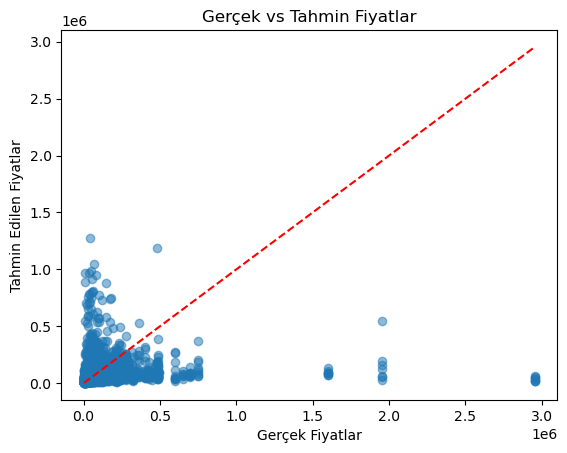

In [9]:
import matplotlib.pyplot as plt

plt.scatter(y_val, y_pred, alpha=0.5)
plt.xlabel("Gerçek Fiyatlar")
plt.ylabel("Tahmin Edilen Fiyatlar")
plt.title("Gerçek vs Tahmin Fiyatlar")
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')  # y=x çizgisi
plt.show()


In [11]:
print(y_train.describe())
print(y_train.head())


count    1.206600e+05
mean     4.394926e+04
std      8.074952e+04
min      2.000000e+03
25%      1.700000e+04
50%      3.079800e+04
75%      4.990000e+04
max      2.954083e+06
Name: price, dtype: float64
7448      20500
84349     13000
71382     83000
129902    21900
51336     10900
Name: price, dtype: int64


In [10]:
# Test verisi tahmini
test_preds = model.predict(X_test)

# Sonuçları kaydet
submission = pd.DataFrame({
    "id": test["id"],
    "price": test_preds
})
submission.to_csv("submission.csv", index=False)
print("Tahminler 'submission.csv' dosyasına kaydedildi.")


Tahminler 'submission.csv' dosyasına kaydedildi.
